<a href="https://colab.research.google.com/github/comchem/Pytorch_DeepLearning_Tutorials/blob/master/Sec5-Convolution_ANN/2-CNN_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='.', train=True, transform=transforms.ToTensor(), download=True)

test_dataset = torchvision.datasets.CIFAR10(
    root='.', train=False, transform=transforms.ToTensor(), download=True)

test_dataset.data.shape   # Color shape 3


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


(10000, 32, 32, 3)

In [4]:
# behaves differently from MNIST / Fashion MNIST
# it is a Numpy array!
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [5]:
# We are working with color images
train_dataset.data.shape

(50000, 32, 32, 3)

In [6]:
# number of classes
K = len(set(train_dataset.targets))
print("number of classes:", K)

number of classes: 10


In [7]:
# Data loader
# Useful because it automatically generates batches in the training loop
# and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [8]:
# Check out what the data loader does
# maps the values to (0,1)
# makes the data of shape (batch size, color, height, width)
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=1,
                                        shuffle=True)

for x, y in tmp_loader:
    print(x)
    print(x.shape)
    print(y.shape)
    break

tensor([[[[0.3765, 0.3725, 0.4824,  ..., 0.3725, 0.4941, 0.4235],
          [0.5451, 0.5098, 0.5176,  ..., 0.4275, 0.4902, 0.4588],
          [0.6078, 0.6157, 0.6000,  ..., 0.4471, 0.4863, 0.4824],
          ...,
          [0.4000, 0.4000, 0.4353,  ..., 0.8588, 0.8667, 0.8588],
          [0.4078, 0.4000, 0.4314,  ..., 0.8627, 0.8549, 0.8510],
          [0.4118, 0.3882, 0.3882,  ..., 0.8471, 0.8431, 0.8392]],

         [[0.3961, 0.3922, 0.4824,  ..., 0.4039, 0.5216, 0.4588],
          [0.5569, 0.5176, 0.5176,  ..., 0.4392, 0.5059, 0.4667],
          [0.6078, 0.6157, 0.5922,  ..., 0.4431, 0.4863, 0.4706],
          ...,
          [0.3922, 0.3922, 0.4275,  ..., 0.8353, 0.8549, 0.8549],
          [0.4000, 0.3922, 0.4235,  ..., 0.8549, 0.8588, 0.8510],
          [0.4039, 0.3804, 0.3804,  ..., 0.8510, 0.8510, 0.8431]],

         [[0.2353, 0.2392, 0.4314,  ..., 0.3137, 0.4549, 0.3529],
          [0.4627, 0.4235, 0.4941,  ..., 0.3490, 0.4392, 0.3647],
          [0.5843, 0.5843, 0.5961,  ..., 0

In [9]:
# Calculation for Flatten dimension

# Output dimensions = floor[ (Input + (2xpadding) - (kernel_size - 1) - 1) / stride + 1 ]

# First Layer : input = 28 * 28 *1 --> kernel_size = 3, stride = 2
input = 32

Hout_layer1 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer1)
input = Hout_layer1

# Second Layer : kernel_size = 3, stride = 2
Hout_layer2 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer2)
input = Hout_layer2

# Third Layer : kernel_size = 3, stride = 2
Hout_layer3 = np.floor((input - (3-1) -1)/2 + 1)
print(Hout_layer3)   

15.0
7.0
3.0


In [10]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()

        # define the conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
            
        # define the linear layers
        self.fc1 = nn.Linear(128*3*3, 1024)
        self.fc2 = nn.Linear(1024,K)            # K input
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 3 * 3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

In [11]:
# Instantiate the model
model = CNN(K)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [13]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [14]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
        
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
    
        # Get train loss and test loss
        train_loss = np.mean(train_loss)   # a little misleading

        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [15]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 1.6817, Test Loss: 1.4669, Duration: 0:00:12.550087
Epoch 2/15, Train Loss: 1.3967, Test Loss: 1.3108, Duration: 0:00:12.278718
Epoch 3/15, Train Loss: 1.2749, Test Loss: 1.2518, Duration: 0:00:12.409926
Epoch 4/15, Train Loss: 1.1866, Test Loss: 1.2224, Duration: 0:00:12.295340
Epoch 5/15, Train Loss: 1.1106, Test Loss: 1.1701, Duration: 0:00:12.338385
Epoch 6/15, Train Loss: 1.0529, Test Loss: 1.1058, Duration: 0:00:12.236397
Epoch 7/15, Train Loss: 0.9943, Test Loss: 1.1024, Duration: 0:00:12.156159
Epoch 8/15, Train Loss: 0.9532, Test Loss: 1.0536, Duration: 0:00:12.228042
Epoch 9/15, Train Loss: 0.9072, Test Loss: 1.0160, Duration: 0:00:12.157512
Epoch 10/15, Train Loss: 0.8708, Test Loss: 1.0360, Duration: 0:00:12.235758
Epoch 11/15, Train Loss: 0.8368, Test Loss: 1.0050, Duration: 0:00:12.329337
Epoch 12/15, Train Loss: 0.8024, Test Loss: 1.0164, Duration: 0:00:12.210100
Epoch 13/15, Train Loss: 0.7734, Test Loss: 0.9973, Duration: 0:00:12.268036
Epoch 14

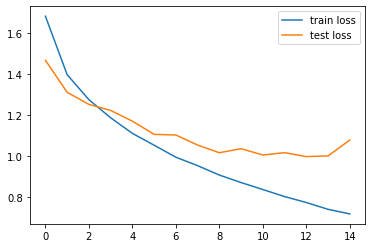

In [16]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [17]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    #print(outputs.shape)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    # print(_, predictions)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)      # _ : result value, predictions : max로 선택된 Digit index (logit function)
    
    # update counts
    n_correct += (predictions == targets).sum().item()   # item : sum까지만 하면 출력이 tensor로 표현되므로 합산만 뽑아냄
    n_total += targets.shape[0]
    
test_acc = n_correct / n_total
print(f'Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}')

Train acc: 0.7264, Test acc: 0.6411


In [18]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = dm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    # color 부여
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
  # Do these results make sense?
  # It's easy to confuse 9 <--> 4, 9 <--> 7, 2 <--> 7, etc.

Confusion matrix, without normalization
[[749  16  38   8   7   1  14  12 106  49]
 [ 53 749   2   4   0   1  10   5  46 130]
 [ 98  11 546  58  78  31  85  41  30  22]
 [ 47  19 108 382  75  89 148  48  45  39]
 [ 51   6 111  38 586  17  94  71  22   4]
 [ 38  15  95 207  68 368  83  78  32  16]
 [ 26   9  48  34  38   8 802  10  12  13]
 [ 35  11  43  33  79  34  31 689   6  39]
 [124  33  10   8   5   2   6   4 776  32]
 [ 67  85  11   6   5   2  22  21  41 740]]


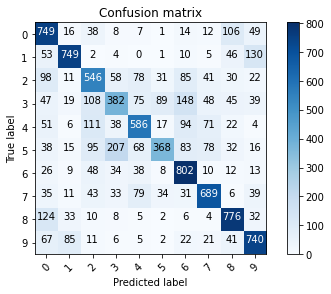

In [19]:
# get all predictions in an array and plot confusion matrix

x_test = test_dataset.data
y_test = test_dataset.targets
p_test = np.array([])                   # p_test : prediction test

for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)

    # Forward pass
    outputs = model(inputs)
    
    # Get prediction
    _, predictions = torch.max(outputs, 1)  
    
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))   # concatenate : 여러개의 array를 붙임
    #print(p_test)
    #p_test2 = np.array(predictions.cpu().numpy())    
    # p_test2와 같이 array를 바로 감쌀수도 있으나, 그러면 concatenate 처럼 For loop 동안에 발생한 모든 array를 붙일 수 없음
    #print(p_test2)
    
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [20]:
# Label mapping
labels = '''airplane = 0
automobile = 1
bird = 2
cat = 3
deer = 4
dog = 5
frog = 6
horse = 7
ship =8
truck = 9'''.split("\n")

In [21]:
labels

['airplane = 0',
 'automobile = 1',
 'bird = 2',
 'cat = 3',
 'deer = 4',
 'dog = 5',
 'frog = 6',
 'horse = 7',
 'ship =8',
 'truck = 9']

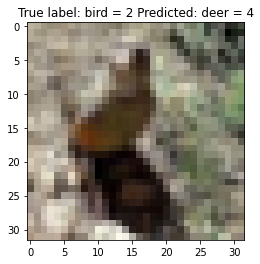

In [22]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title('True label: %s Predicted: %s' % (labels[y_test[i]], labels[int(p_test[i])]));